In [1]:
import os, sys
import importlib
import torch

import numpy as np

from utils import load, vis

In [2]:
importlib.reload(vis)

data_folder = "../quickdraw/train_simplified/"
access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
trainGenerator = vis.ImageGenerator(access_file_generator)

In [3]:
gen = trainGenerator.generateImages()

X.shape: (128, 28, 28, 4)
y.shape: (128, 8)


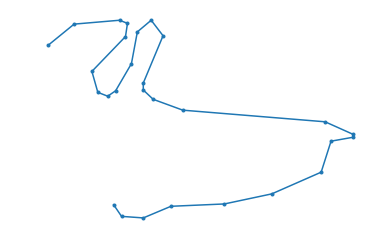

In [4]:
%matplotlib inline
X, y = next(gen)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

array([0., 0., 1., 0., 0., 0., 0., 0.])

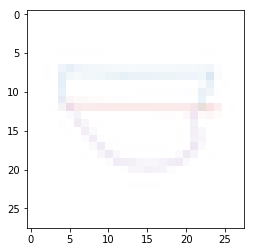

In [5]:
import matplotlib.pyplot as plt
plt.imshow(X[0].astype(int))
y[0]

# Building PyTorch CNN Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim


class LeNet(nn.Module):
    # Here we define our network structure
    def __init__(self, cdim=8):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 5).double() 
        self.conv2 = nn.Conv2d(6,16,5).double()
        self.fc1   = nn.Linear(256,120).double()
        self.fc2   = nn.Linear(120, 84).double() 
        self.fc3   = nn.Linear(84, cdim).double()
        
    # Here we define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x)) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()[1:]
        return np.prod(size)


net = LeNet(cdim=y.shape[1])

In [7]:
xtest = ag.Variable(torch.from_numpy(np.moveaxis(X, [-1], [1])), requires_grad=False)
ypred = net(xtest)
acc   = 100 * np.mean(np.argmax(y,1) == ypred.data.numpy().T.argmax(axis=0))
print('Classification Accuracy on Initialized LeNet = {0:.3}%'.format(acc))

Classification Accuracy on Initialized LeNet = 11.7%


In [8]:
B     = 128              # Minibatch size
T     = 10               # Number of epochs
gamma = .001             # learning rate
rho   = .9               # momentum

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    net.parameters(),
    lr=gamma,
    momentum=rho
)

In [ ]:
if torch.cuda.is_available():
    net = net.cuda()

for epoch in range(T):
    running_loss, k   = 0.0, 0
    for X,y in trainGenerator.generateImages():
        inputs = ag.Variable(torch.from_numpy(np.moveaxis(X, [-1], [1])), requires_grad=False)
        labels = ag.Variable(torch.from_numpy(np.argmax(y, 1)), requires_grad=False)
        
        if torch.cuda.is_available():
            inputs  = inputs.cuda()
            labels  = labels.cuda()
        
        # Initialize the gradiaent to zero
        optimizer.zero_grad()
        output = net(inputs)
        loss   = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss[0]
        k += 1
        if k % 10 == 9:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, k + 1, running_loss/10))
            running_loss = 0.0

print('Finished Training')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,    10] loss: 0.196
[1,    20] loss: 0.206
[1,    30] loss: 0.200
[1,    40] loss: 0.187
[1,    50] loss: 0.172
[1,    60] loss: 0.159
